In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.transforms import Compose, ToTensor, Lambda, Normalize

# Task - 1

In [2]:
def _create_batch(unbatched_data, unbatched_label, unbatched_test_data, unbatched_test_label):
    unbatched_data = torch.split(unbatched_data, 100)
    unbatched_label = torch.split(unbatched_label, 100)
    unbatched_test_data = torch.split(unbatched_test_data, 100)
    unbatched_test_label = torch.split(unbatched_test_label, 100)
    return unbatched_data, unbatched_label, unbatched_test_data, unbatched_test_label


def get_dataset():
    # dataset
    transform = Compose([
        ToTensor(),
        Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ])

    target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), 1))

    train_dataset = CIFAR10('./data', train=True, download=True, transform=transform, target_transform=target_transform)
    test_dataset = CIFAR10('./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=len(train_dataset))
    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

    train_data, train_label = next(iter(train_loader))
    test_data, test_label = next(iter(test_loader))

    print('train data: {}, train label: {}'.format(train_data.size(), train_label.size()))
    print('test data: {}, test label: {}'.format(test_data.size(), test_label.size()))

    sorted_train_label_arg = torch.argsort(torch.argmax(train_label, dim=1))
    sorted_train_label = train_label[sorted_train_label_arg]
    sorted_train_data = train_data[sorted_train_label_arg]

    train_data_sampled = []
    train_label_sampled = []
    for class_idx in range(10):
        class_idx = class_idx * 5000
        train_data_sampled.append(sorted_train_data[class_idx:(class_idx + 1000)])
        train_label_sampled.append(sorted_train_label[class_idx:(class_idx + 1000)])

    rand_idx = torch.randperm(10000)
    train_data_sampled = torch.concat(train_data_sampled, dim=0)[rand_idx]
    train_label_sampled = torch.concat(train_label_sampled, dim=0)[rand_idx]
    print(
        'train_data_sampled: {}, train_label_sampled: {}'.format(train_data_sampled.size(), train_label_sampled.size()))

    train_data_sampled, train_label_sampled, test_data, test_label = _create_batch(train_data_sampled,
                                                                                   train_label_sampled, test_data,
                                                                                   test_label)
    print('train_data_sampled: {}, train_label_sampled: {}'.format(len(train_data_sampled), len(train_label_sampled)))
    print('train_data_sampled: {}, train_label_sampled: {}'.format(train_data_sampled[0].size(),
                                                                   train_label_sampled[0].size()))

    return train_data_sampled, train_label_sampled, test_data, test_label

In [3]:
def train(train_data_sampled, train_label_sampled, test_data, test_label, augmentation=None, num_epoch=100, lr=0.0001):
    model = resnet18(weights=ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(512, 10)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    model = model.to(device)

    running_loss = []
    running_acc = []
    running_train_acc = []
    loss = None

    for epoch in range(num_epoch):
        for idx, (data, label) in enumerate(zip(train_data_sampled, train_label_sampled)):
            model.train()
            if augmentation is not None:
                data, label = augmentation(data, label)
            data, label = data.to(device), label.to(device)

            optimizer.zero_grad()
            preds = model(data)
            loss = criterion(preds, label)
            loss.backward()
            optimizer.step()
            running_loss.append(loss.item())

            # test
            # if (idx + 1) % 10 == 0:
        model.eval()
        tot_acc = torch.zeros(1).to(device)
        test_data_size = 0
        with torch.no_grad():
            for test_data_batch, test_label_batch in zip(test_data, test_label):
                test_data_batch, test_label_batch = test_data_batch.to(device), test_label_batch.to(device)
                test_preds = model(test_data_batch)
                test_preds = torch.argmax(test_preds, dim=1)
                tot_acc = tot_acc + torch.count_nonzero((test_preds == test_label_batch).long())
                test_data_size += test_data_batch.size(0)
            running_acc.append(tot_acc.item() / test_data_size)

        tot_acc_train = torch.zeros(1).to(device)
        train_data_size = 0
        with torch.no_grad():
            for train_data_batch, train_label_batch in zip(train_data_sampled, train_label_sampled):
                train_data_batch, train_label_batch = train_data_batch.to(device), train_label_batch.to(device)
                train_preds = model(train_data_batch)
                train_preds = torch.argmax(train_preds, dim=1)
                ground_truth = torch.argmax(train_label_batch, dim=1)
                tot_acc_train = tot_acc_train + torch.count_nonzero((train_preds == ground_truth).long())
                train_data_size += train_data_batch.size(0)
            running_train_acc.append(tot_acc_train.item() / train_data_size)
            # print(tot_acc)
            # print(test_data_size)
        print('epoch: {}, loss: {}, test acc: {}, train acc: {}'.format(epoch + 1, loss, tot_acc.item() / test_data_size, tot_acc_train.item() / train_data_size))

    plt.figure(figsize=(10, 5))
    plt.plot(list(range(len(running_loss))), running_loss)
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.title('loss vs. iteration')
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(list(range(len(running_acc))), running_acc)
    plt.plot(list(range(len(running_train_acc))), running_train_acc)
    plt.xlabel('iteration')
    plt.ylabel('acc')
    plt.title('acc vs. iteration')
    plt.legend(['test acc', 'train acc'], loc='lower right')
    plt.show()

    return running_loss, running_acc, running_train_acc

Files already downloaded and verified
Files already downloaded and verified
train data: torch.Size([50000, 3, 32, 32]), train label: torch.Size([50000, 10])
test data: torch.Size([10000, 3, 32, 32]), test label: torch.Size([10000])
train_data_sampled: torch.Size([10000, 3, 32, 32]), train_label_sampled: torch.Size([10000, 10])
train_data_sampled: 100, train_label_sampled: 100
train_data_sampled: torch.Size([100, 3, 32, 32]), train_label_sampled: torch.Size([100, 10])
epoch: 1, loss: 0.08269018679857254, test acc: 0.3095, train acc: 0.3464
epoch: 2, loss: 0.06839144229888916, test acc: 0.4322, train acc: 0.5029
epoch: 3, loss: 0.05558766424655914, test acc: 0.4997, train acc: 0.6115
epoch: 4, loss: 0.045817699283361435, test acc: 0.5453, train acc: 0.6998
epoch: 5, loss: 0.037445105612277985, test acc: 0.5722, train acc: 0.7686
epoch: 6, loss: 0.029781831428408623, test acc: 0.5866, train acc: 0.8254
epoch: 7, loss: 0.023174161091446877, test acc: 0.5944, train acc: 0.8676
epoch: 8, los

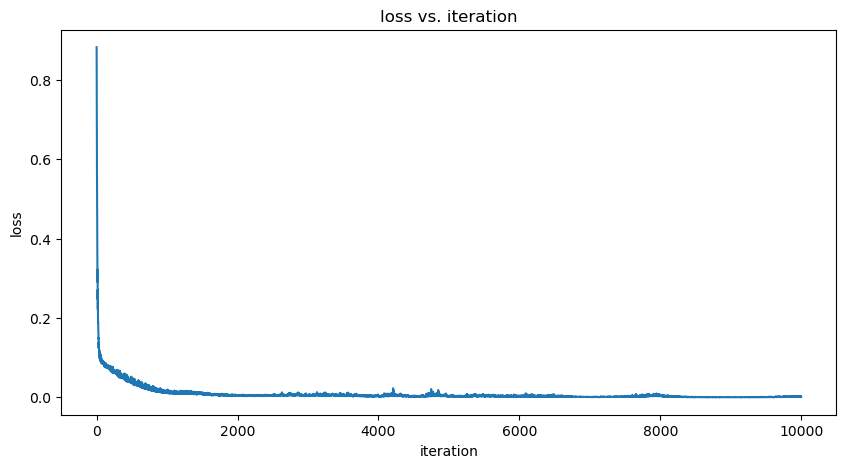

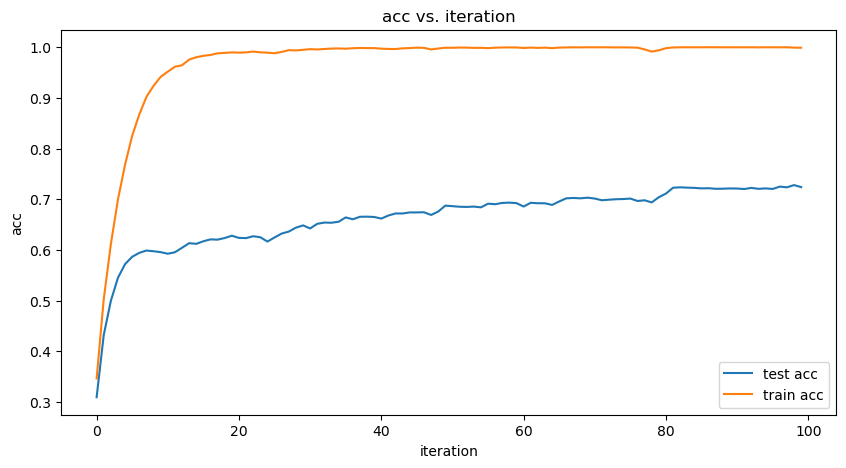

In [5]:
train_X, train_y, test_X, test_y = get_dataset()
running_loss_without_aug, running_acc_without_aug, running_train_acc_without_aug = train(train_X, train_y, test_X, test_y)

The final results of the training without augmentation is the following:
- test accuracy: 0.724
- train accuracy: 0.999
- loss: 0.0008

# Task - 2

In [10]:
def mixup(data_batch, label_batch, alpha):
    mixup_idx = np.random.choice(data_batch.size(0), data_batch.size(0))
    mixup_samples = data_batch[mixup_idx]
    mixup_labels = label_batch[mixup_idx]
    lambda_arr = torch.tensor(np.random.beta(alpha, alpha, size=data_batch.size(0)))
    for sample_idx, (data_sample, label_sample) in enumerate(zip(data_batch, label_batch)):
        mixup_samples[sample_idx] = lambda_arr[sample_idx] * data_sample + (1 - lambda_arr[sample_idx]) * mixup_samples[
            sample_idx]
        mixup_labels[sample_idx] = lambda_arr[sample_idx] * label_sample + (1 - lambda_arr[sample_idx]) * mixup_labels[
            sample_idx]
    return mixup_samples, mixup_labels

Files already downloaded and verified
Files already downloaded and verified
train data: torch.Size([50000, 3, 32, 32]), train label: torch.Size([50000, 10])
test data: torch.Size([10000, 3, 32, 32]), test label: torch.Size([10000])
train_data_sampled: torch.Size([10000, 3, 32, 32]), train_label_sampled: torch.Size([10000, 10])
train_data_sampled: 100, train_label_sampled: 100
train_data_sampled: torch.Size([100, 3, 32, 32]), train_label_sampled: torch.Size([100, 10])
epoch: 1, loss: 0.06990260630846024, test acc: 0.2959, train acc: 0.3283
epoch: 2, loss: 0.06399860233068466, test acc: 0.3962, train acc: 0.4523
epoch: 3, loss: 0.05819224938750267, test acc: 0.4819, train acc: 0.5513
epoch: 4, loss: 0.05867232754826546, test acc: 0.5386, train acc: 0.6223
epoch: 5, loss: 0.0491856150329113, test acc: 0.5883, train acc: 0.6867
epoch: 6, loss: 0.04320608079433441, test acc: 0.6203, train acc: 0.7292
epoch: 7, loss: 0.042134735733270645, test acc: 0.6463, train acc: 0.7689
epoch: 8, loss: 0

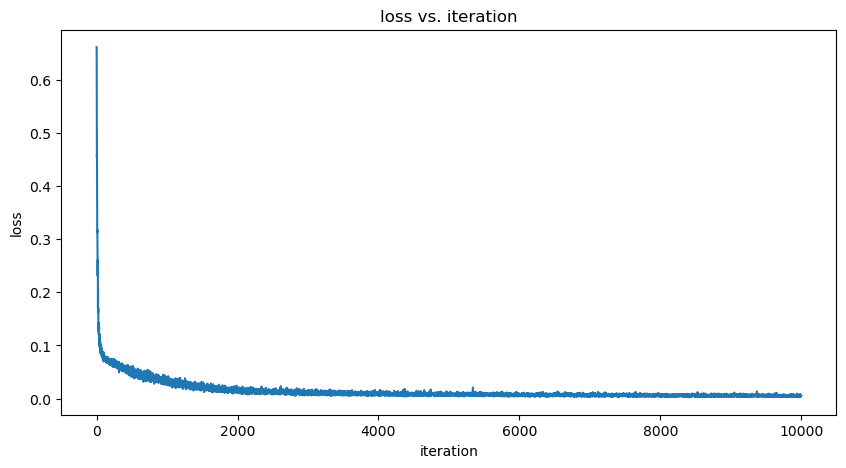

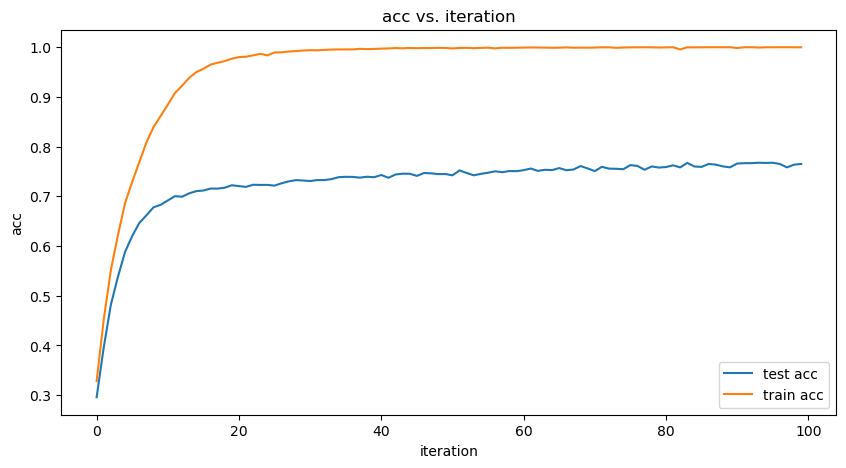

Files already downloaded and verified
Files already downloaded and verified
train data: torch.Size([50000, 3, 32, 32]), train label: torch.Size([50000, 10])
test data: torch.Size([10000, 3, 32, 32]), test label: torch.Size([10000])
train_data_sampled: torch.Size([10000, 3, 32, 32]), train_label_sampled: torch.Size([10000, 10])
train_data_sampled: 100, train_label_sampled: 100
train_data_sampled: torch.Size([100, 3, 32, 32]), train_label_sampled: torch.Size([100, 10])
epoch: 1, loss: 0.07491793483495712, test acc: 0.2807, train acc: 0.312
epoch: 2, loss: 0.06374610215425491, test acc: 0.3781, train acc: 0.417
epoch: 3, loss: 0.055627405643463135, test acc: 0.4621, train acc: 0.519
epoch: 4, loss: 0.05430176109075546, test acc: 0.5204, train acc: 0.575
epoch: 5, loss: 0.04955452308058739, test acc: 0.5805, train acc: 0.6548
epoch: 6, loss: 0.04990536719560623, test acc: 0.6106, train acc: 0.6948
epoch: 7, loss: 0.04007405787706375, test acc: 0.6397, train acc: 0.7341
epoch: 8, loss: 0.03

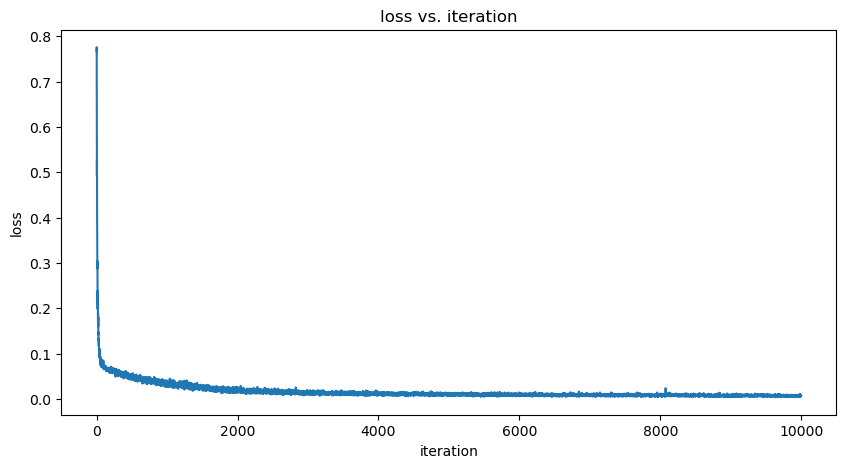

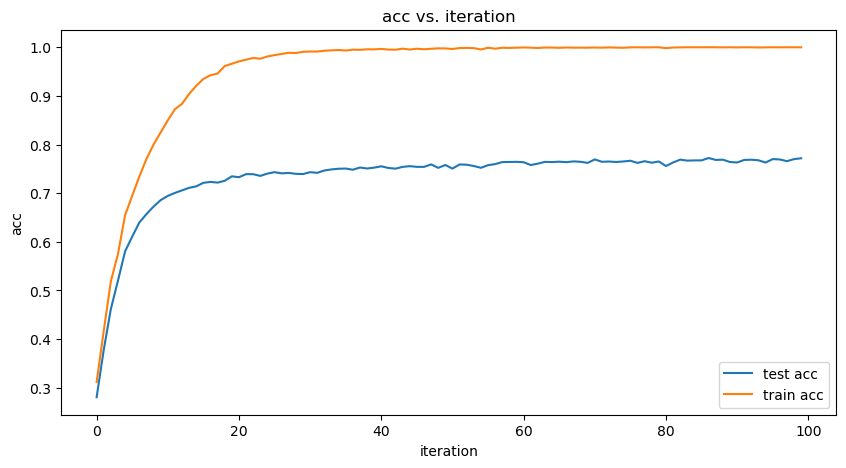

In [6]:
train_X, train_y, test_X, test_y = get_dataset()
running_loss_mixup_2, running_acc_mixup_2, running_train_acc_mixup_2 = train(train_X, train_y, test_X, test_y, augmentation=lambda x, y: mixup(x, y, 0.2))
train_X, train_y, test_X, test_y = get_dataset()
running_loss_mixup_4, running_acc_mixup_4, running_train_acc_mixup_4 = train(train_X, train_y, test_X, test_y, augmentation=lambda x, y: mixup(x, y, 0.4))

The final results of the training with mixup (alpha = 0.2) is the following:
- test accuracy: 0.7651
- train accuracy: 0.998
- loss: 0.0005

The final results of the training with mixup (alpha = 0.4) is the following:
- test accuracy: 0.7717
- train accuracy: 0.997
- loss: 0.0008

# Task - 3

In [11]:
def cutout(data_batch, label_batch, k=16):
    cutout_mask = np.random.choice(2, data_batch.size(0)) # if zero no cutoff if one cutoff
    cutout_samples = torch.zeros(data_batch.size())
    for sample_idx, (data_sample, label_sample) in enumerate(zip(data_batch, label_batch)):
        if cutout_mask[sample_idx] == 1:
            random_row = np.random.choice(data_sample.size(1), 1)[0]
            random_col = np.random.choice(data_sample.size(2), 1)[0]
            if k % 2 == 0:
                cutout_row_min, cutout_row_max = int(max(0, random_row - ((k / 2) - 1))), int(min(data_sample.size(1) - 1, random_row + (k / 2)))
                cutout_col_min, cutout_col_max = int(max(0, random_col - ((k / 2) - 1))), int(min(data_sample.size(1) - 1, random_col + (k / 2)))
            else:
                cutout_row_min, cutout_row_max = int(max(0, random_row - ((k - 1) / 2))), int(min(data_sample.size(1) - 1, random_row + ((k - 1) / 2)))
                cutout_col_min, cutout_col_max = int(max(0, random_col - ((k - 1) / 2))), int(min(data_sample.size(1) - 1, random_col + ((k - 1) / 2)))
            zero_filter = torch.zeros((data_sample.size(0), cutout_row_max - cutout_row_min + 1, cutout_col_max - cutout_col_min + 1))
            cutout_samples[sample_idx] = data_sample
            cutout_samples[sample_idx, :, cutout_row_min:(cutout_row_max + 1), cutout_col_min:(cutout_col_max + 1)] = zero_filter

    return cutout_samples, label_batch

Files already downloaded and verified
Files already downloaded and verified
train data: torch.Size([50000, 3, 32, 32]), train label: torch.Size([50000, 10])
test data: torch.Size([10000, 3, 32, 32]), test label: torch.Size([10000])
train_data_sampled: torch.Size([10000, 3, 32, 32]), train_label_sampled: torch.Size([10000, 10])
train_data_sampled: 100, train_label_sampled: 100
train_data_sampled: torch.Size([100, 3, 32, 32]), train_label_sampled: torch.Size([100, 10])
epoch: 1, loss: 0.09869825094938278, test acc: 0.1917, train acc: 0.197
epoch: 2, loss: 0.08894947916269302, test acc: 0.2686, train acc: 0.288
epoch: 3, loss: 0.08612920343875885, test acc: 0.3341, train acc: 0.3591
epoch: 4, loss: 0.0845990777015686, test acc: 0.3889, train acc: 0.4244
epoch: 5, loss: 0.0819743275642395, test acc: 0.455, train acc: 0.489
epoch: 6, loss: 0.08564885705709457, test acc: 0.5094, train acc: 0.5429
epoch: 7, loss: 0.08172920346260071, test acc: 0.5487, train acc: 0.5836
epoch: 8, loss: 0.07927

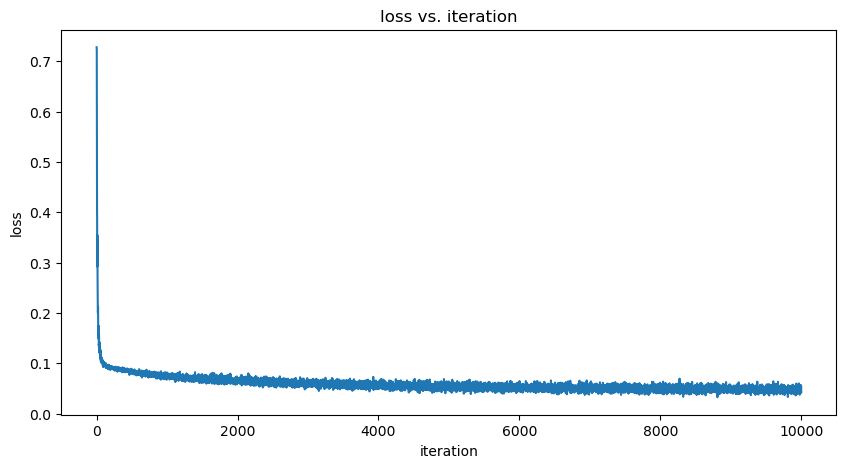

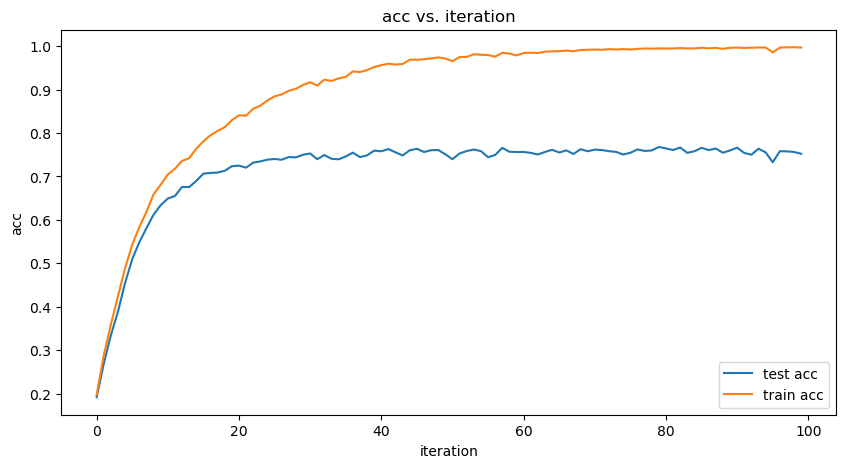

In [7]:
train_X, train_y, test_X, test_y = get_dataset()
running_loss_cutout, running_acc_cutout, running_train_acc_cutout = train(train_X, train_y, test_X, test_y, augmentation=cutout)

The final results of the training with cutout is the following:
- test accuracy: 0.7523
- train accuracy: 0.9969
- loss: 0.05

# Task - 4

In [12]:
def standard_augmentation(data_batch, label_batch, k=4):
    standard_samples = torch.zeros(data_batch.size())
    for sample_idx, (data_sample, label_sample) in enumerate(zip(data_batch, label_batch)):
        upward_k, rightward_k = np.random.choice(list(range(-1*k, k+1)), 2).astype(int)
        if upward_k > 0:
            standard_samples[sample_idx, :, :(data_sample.size(1) - upward_k), :] = data_sample[:, upward_k:, :]
        else:
            upward_k = -1 * upward_k
            standard_samples[sample_idx, :, upward_k:, :] = data_sample[:, :(data_sample.size(1) - upward_k), :]

        if rightward_k > 0:
            standard_samples[sample_idx, :, :, rightward_k:] = data_sample[:, :, :(data_sample.size(2) - rightward_k)]
        else:
            rightward_k = -1 * rightward_k
            standard_samples[sample_idx, :, :, :(data_sample.size(2) - rightward_k)] = data_sample[:, :, rightward_k:]

        flip_or_not = np.random.choice(2, 1) # if zero not flip if one flip
        if flip_or_not == 1:
            flip_r = torch.fliplr(standard_samples[sample_idx, 0, :, :])
            flip_g = torch.fliplr(standard_samples[sample_idx, 1, :, :])
            flip_b = torch.fliplr(standard_samples[sample_idx, 2, :, :])
            standard_samples[sample_idx] = torch.stack([flip_r, flip_g, flip_b])
    return standard_samples, label_batch

Files already downloaded and verified
Files already downloaded and verified
train data: torch.Size([50000, 3, 32, 32]), train label: torch.Size([50000, 10])
test data: torch.Size([10000, 3, 32, 32]), test label: torch.Size([10000])
train_data_sampled: torch.Size([10000, 3, 32, 32]), train_label_sampled: torch.Size([10000, 10])
train_data_sampled: 100, train_label_sampled: 100
train_data_sampled: torch.Size([100, 3, 32, 32]), train_label_sampled: torch.Size([100, 10])
epoch: 1, loss: 0.0879349485039711, test acc: 0.3166, train acc: 0.3239
epoch: 2, loss: 0.07401793450117111, test acc: 0.4416, train acc: 0.4655
epoch: 3, loss: 0.06605496257543564, test acc: 0.5302, train acc: 0.569
epoch: 4, loss: 0.0590493343770504, test acc: 0.5943, train acc: 0.6414
epoch: 5, loss: 0.05434347689151764, test acc: 0.6408, train acc: 0.6943
epoch: 6, loss: 0.05159439146518707, test acc: 0.6683, train acc: 0.737
epoch: 7, loss: 0.043481454253196716, test acc: 0.6892, train acc: 0.7699
epoch: 8, loss: 0.04

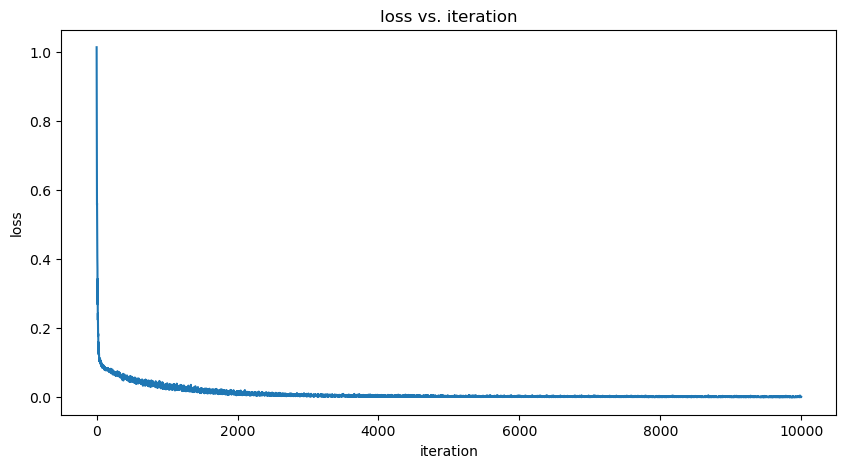

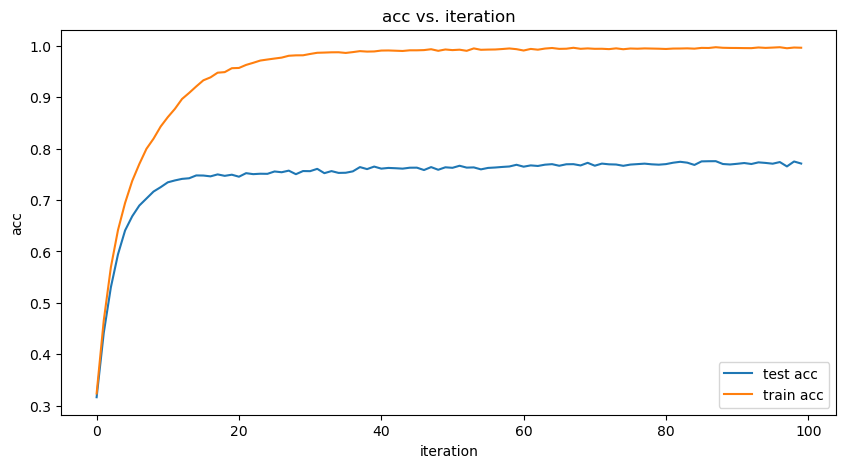

In [8]:
train_X, train_y, test_X, test_y = get_dataset()
running_loss_standard, running_acc_standard, running_train_acc_standard = train(train_X, train_y, test_X, test_y, augmentation=standard_augmentation)

The final results of the training with standard augmentation is the following:
- test accuracy: 0.7708
- train accuracy: 0.9959
- loss: 0.0008

# Task - 5

In [13]:
def combined_augmentation(data_batch, label_batch, alpha, k_cutout=16, k_standard=4):
    data_batch, label_batch = standard_augmentation(data_batch, label_batch, k=k_standard)
    data_batch, label_batch = cutout(data_batch, label_batch, k=k_cutout)
    return mixup(data_batch, label_batch, alpha)

Files already downloaded and verified
Files already downloaded and verified
train data: torch.Size([50000, 3, 32, 32]), train label: torch.Size([50000, 10])
test data: torch.Size([10000, 3, 32, 32]), test label: torch.Size([10000])
train_data_sampled: torch.Size([10000, 3, 32, 32]), train_label_sampled: torch.Size([10000, 10])
train_data_sampled: 100, train_label_sampled: 100
train_data_sampled: torch.Size([100, 3, 32, 32]), train_label_sampled: torch.Size([100, 10])
epoch: 1, loss: 0.08883503079414368, test acc: 0.2113, train acc: 0.2114
epoch: 2, loss: 0.07770182937383652, test acc: 0.2636, train acc: 0.2715
epoch: 3, loss: 0.08223831653594971, test acc: 0.3205, train acc: 0.3266
epoch: 4, loss: 0.07607375085353851, test acc: 0.3591, train acc: 0.3757
epoch: 5, loss: 0.07492589205503464, test acc: 0.4129, train acc: 0.4217
epoch: 6, loss: 0.07338246703147888, test acc: 0.4418, train acc: 0.4524
epoch: 7, loss: 0.07091926783323288, test acc: 0.4661, train acc: 0.4787
epoch: 8, loss: 0

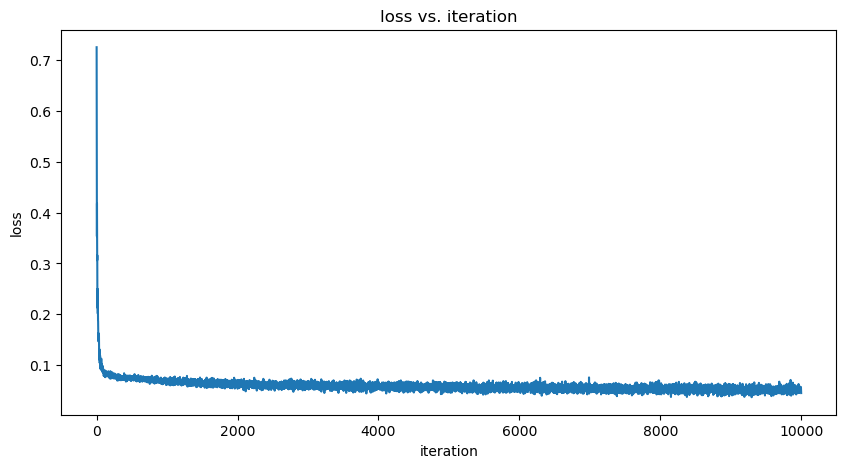

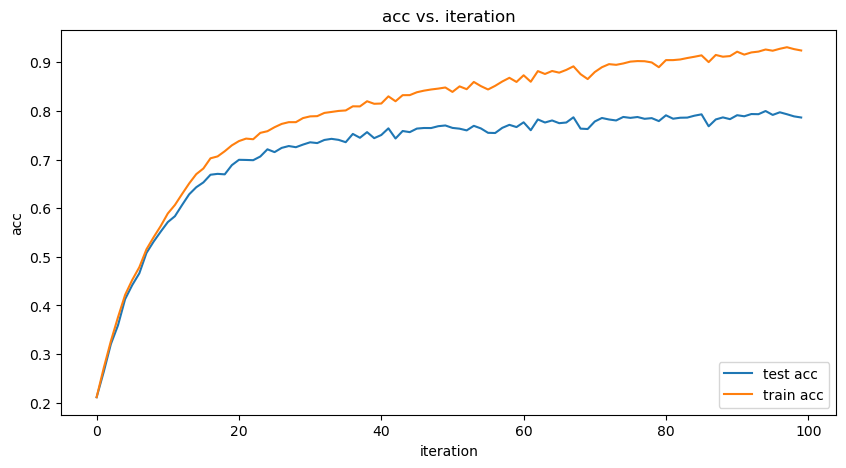

Files already downloaded and verified
Files already downloaded and verified
train data: torch.Size([50000, 3, 32, 32]), train label: torch.Size([50000, 10])
test data: torch.Size([10000, 3, 32, 32]), test label: torch.Size([10000])
train_data_sampled: torch.Size([10000, 3, 32, 32]), train_label_sampled: torch.Size([10000, 10])
train_data_sampled: 100, train_label_sampled: 100
train_data_sampled: torch.Size([100, 3, 32, 32]), train_label_sampled: torch.Size([100, 10])
epoch: 1, loss: 0.08228155970573425, test acc: 0.1736, train acc: 0.1833
epoch: 2, loss: 0.07363782823085785, test acc: 0.2311, train acc: 0.2375
epoch: 3, loss: 0.07395341992378235, test acc: 0.2817, train acc: 0.2982
epoch: 4, loss: 0.07137056440114975, test acc: 0.3307, train acc: 0.3375
epoch: 5, loss: 0.06691642850637436, test acc: 0.3779, train acc: 0.3855
epoch: 6, loss: 0.06868121773004532, test acc: 0.4181, train acc: 0.4171
epoch: 7, loss: 0.0687163695693016, test acc: 0.4624, train acc: 0.4706
epoch: 8, loss: 0.

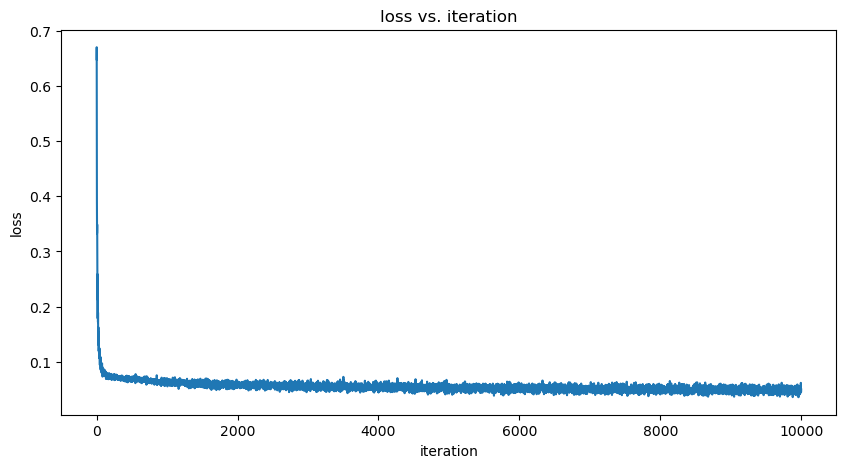

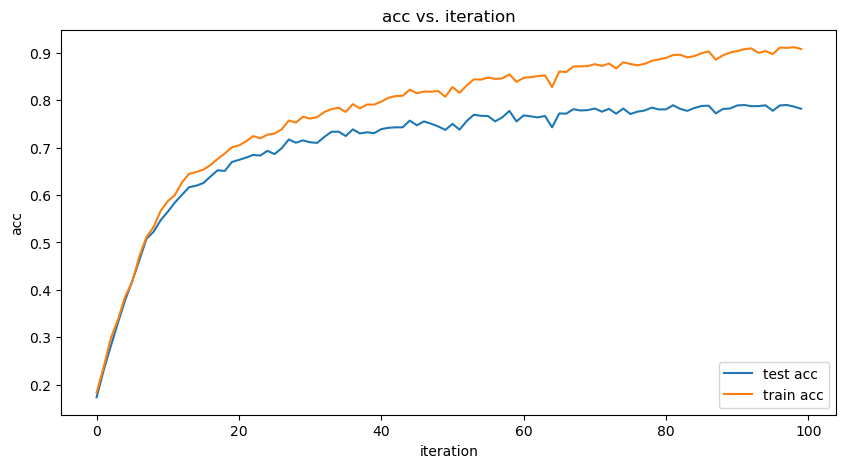

In [9]:
train_X, train_y, test_X, test_y = get_dataset()
running_loss_combined_2, running_acc_combined_2, running_train_acc_combined_2 = train(train_X, train_y, test_X, test_y, augmentation=lambda x, y: combined_augmentation(x, y, 0.2))
train_X, train_y, test_X, test_y = get_dataset()
running_loss_combined_4, running_acc_combined_4, running_train_acc_combined_4 = train(train_X, train_y, test_X, test_y, augmentation=lambda x, y: combined_augmentation(x, y, 0.4))

The final results of the training with all augmentations (alpha = 0.2) is the following:
- test accuracy: 0.7865
- train accuracy: 0.9243
- loss: 0.04

The final results of the training with all augmentations (alpha = 0.4) is the following:
- test accuracy: 0.7817
- train accuracy: 0.9077
- loss: 0.04

Combining the augmentations increased the test accuracy for the training. Also, augmentations reduce the gap between train accuracy and test accuracy. Based on the convergence of the loss, it similar to the convergence with other augmentation methods which is very sharp.

# Task 6

Based on the results the convergence of the loss is similar in the experiments with mixup and standard augmentation and without augmentation experiment. However, for the cutout and combined experiments the loss is not close as other experiments. It could be because the cutout method remove some information from the image. Also, we can see this in the training accuracy. The training accuracy is not good as other experiments in cutout augmentation experiment. However, even if the training accuracy is dropped and the loss is increased in the cutout augmentation it works better than the experiment without augmentation. Also, when applying all the augmentation techniques the final test accuracy is increased.